In [1]:
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import timeit
import matplotlib.pyplot as plt
import urllib.request
from google.colab import drive
import math

# Check if GPU if available

In [2]:
# check if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
    torch.device('cuda')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


# RNN Model Definition: LSTM and GRU

In [3]:
class Model(nn.Module):
    def __init__(self, vocab_size, hidden_size, layer_num, dropout, winit, rnn_type):
        super().__init__()

        # Initialize the model parameters
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.winit = winit
        self.embed = Embed(vocab_size, hidden_size)
        self.rnn_type = rnn_type

        # Create GRU or LSTM layers based on the specified rnn_type
        if rnn_type == 'LSTM':
            self.rnns = [nn.LSTM(hidden_size, hidden_size) for i in range(layer_num)]
        else:
            self.rnns = [nn.GRU(hidden_size, hidden_size) for i in range(layer_num)]

        self.rnns = nn.ModuleList(self.rnns)
        self.fc = Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)

        # Initialize parameters using the reset_parameters method
        self.reset_parameters()

    # Reset parameters using uniform initialization within the range [-winit, winit]
    def reset_parameters(self):
        for param in self.parameters():
            nn.init.uniform_(param, -self.winit, self.winit)

    # Initialize hidden states for the RNN layers
    def state_init(self, batch_size,rnn_type):

        # Get the device from the first parameter's device attribute
        dev = next(self.parameters()).device

        # Create the initial states based on rnn_type
        if rnn_type == 'LSTM':
            states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev), torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        else:
            states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        return states

    # The detach method takes a list of states (hidden and cell states) and applies detach() to each tensor. This is used during training to detach the previous states from the computation graph, preventing gradient flow from the previous time steps.
    def detach(self, states,rnn_type):
        if rnn_type =='LSTM':
          return [(h.detach(), c.detach()) for (h,c) in states]                 # c for cell state (memory) and h for hiddent state (information that is passed along through time)
        else:
          return [h.detach() for h in states]                                   # if GRU : it only detaches the hidden state.

    def forward(self, x, states):
        x = self.embed(x)                                                       # Passes the input sequence through the embedding layer.
        x = self.dropout(x)                                                     # Applies dropout to the embedded sequence.
        for i, rnn in enumerate(self.rnns):                                     # Iterates over the layers, applying the computations and dropout.
            x, states[i] = rnn(x, states[i])
            x = self.dropout(x)                                                 # Passes the final hidden state through the linear layer to get scores for each token in the vocabulary.
        scores = self.fc(x)
        return scores, states


# Load the data

In [5]:
drive.mount('/content/drive')
def data_init():
    # Update file paths based on the location in your Google Drive
    trn_path = '/content/drive/MyDrive/HW 2 - Deep Learning/PTB/ptb.train.txt'
    vld_path = '/content/drive/MyDrive/HW 2 - Deep Learning/PTB/ptb.valid.txt'
    tst_path = '/content/drive/MyDrive/HW 2 - Deep Learning/PTB/ptb.test.txt'

    with open(trn_path) as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open(vld_path) as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open(tst_path) as f:
        file = f.read()
        tst = file[1:].split(' ')

    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]

    return np.array(trn).reshape(-1, 1), np.array(vld).reshape(-1, 1), np.array(tst).reshape(-1, 1), len(words)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Linear Layer Implementation : Custom Fully Connected (FC) Module

In [6]:
class Linear(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b = nn.Parameter(torch.Tensor(hidden_size))

    def forward(self, x):
        z = torch.addmm(self.b, x.view(-1, x.size(2)), self.W.t())              #.view() flattens the input which has dimensionality [T,B,X] to dimenstionality [T*B, X].
        return z

    # provides a string representation of the linear layer, indicating its input size and output size.
    def __repr__(self):
        return "FC(input: {}, output: {})".format(self.input_size, self.hidden_size)


# Embedding Layer Implementation : Custom Embedding Module

In [ ]:
class Embed(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.W = nn.Parameter(torch.Tensor(vocab_size, embed_size))

    def forward(self, x):
        return self.W[x]

    def __repr__(self):
        return "Embedding(vocab: {}, embedding: {})".format(self.vocab_size, self.embed_size)

# Loss Calculation and Perplexity Evaluation Functions

In [7]:
def minibatch(data, batch_size, seq_length):
    data = torch.tensor(data, dtype = torch.int64)
    num_batches = data.size(0)//batch_size
    data = data[:num_batches*batch_size]
    data=data.view(batch_size,-1)
    dataset = []
    for i in range(0,data.size(1)-1,seq_length):
        seqlen=int(np.min([seq_length,data.size(1)-1-i]))
        if seqlen<data.size(1)-1-i:
            x=data[:,i:i+seqlen].transpose(1, 0)
            y=data[:,i+1:i+seqlen+1].transpose(1, 0)
            dataset.append((x, y))
    return dataset

def nll_loss(scores, y):
    batch_size = y.size(1)
    expscores = scores.exp()
    probabilities = expscores / expscores.sum(1, keepdim = True)
    answerprobs = probabilities[range(len(y.reshape(-1))), y.reshape(-1)]
    return torch.mean(-torch.log(answerprobs) * batch_size)

def perplexity(data, model,rnn_type):
    with torch.no_grad():
        losses = []
        states = model.state_init(batch_size,rnn_type)
        for x, y in data:
            scores, states = model(x, states)
            loss = nll_loss(scores, y)
            losses.append(loss.data.item()/batch_size)
    return np.exp(np.mean(losses))

# Training Loop with Learning Rate Schedule and Convergence Monitoring


In [8]:
def train(data, model, epochs, epoch_threshold, lr, factor, max_norm,rnn_type):
    train_data, validation_data, test_data = data
    tic = timeit.default_timer()
    total_words = 0

    # Lists to store data for convergence graph
    train_perplexity = []
    test_perplexity = []
    minial_valid_perplexity = np.Inf

    print("Starting training.\n")
    for epoch in range(epochs):

        print("trained over " + str(len(train_data)))

        states = model.state_init(batch_size,rnn_type)
        model.train()
        if epoch > epoch_threshold:
            lr = lr / factor

        for i, (x, y) in enumerate(train_data):
            total_words += x.numel()
            model.zero_grad()
            states = model.detach(states,rnn_type)
            scores, states = model(x, states)
            loss = nll_loss(scores, y)
            loss.backward()


            with torch.no_grad():
                norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm)
                for param in model.parameters():
                    param -= lr * param.grad

            if i % (len(train_data)//10) == 0:
                toc = timeit.default_timer()

                percent_of_batch = math.ceil((i * 100) / len(train_data))
                if percent_of_batch == 0:
                  percent_of_batch = 1
                else :
                  percent_of_batch = math.ceil((i * 100) / len(train_data))

                print("batch :{:d} % of train data , ".format(percent_of_batch) +
                      "train loss = {:.3f}, ".format(loss.item()/batch_size) +
                      "learning rate = {:.3f}, ".format(lr))
        model.eval()
        val_perp = perplexity(validation_data, model,rnn_type)

        if val_perp <= minial_valid_perplexity:
            torch.save(model.state_dict(), 'model_cifar.pt')
            minial_valid_perplexity = val_perp

        epoch_train_perplexity = perplexity(train_data, model, rnn_type)
        epoch_test_perplexity = perplexity(test_data, model, rnn_type)
        train_perplexity.append(epoch_train_perplexity)
        test_perplexity.append(epoch_test_perplexity)
        print("Epoch : {:d}/{:d} \n            => Validation set perplexity : {:.3f}".format(epoch+1, epochs, val_perp))
        print("-----------------------------------------------\n")
    model.load_state_dict(torch.load('model_cifar.pt'))
    tst_perp = perplexity(test_data, model,rnn_type)
    print("validation preplexity : {:.3f}".format(val_perp))
    print("Training is over.")
    return train_perplexity, test_perplexity, val_perp

# Convergence Plotting with Final Perplexity Values

In [9]:
def plot_convergence(n_epochs, test_perplexity, train_perplexity, title):

    plt.plot(range(n_epochs), test_perplexity, label = "Test")
    plt.plot(range(n_epochs), train_perplexity, label = "Train")

    plt.scatter(n_epochs - 1, test_perplexity[-1], color='blue', marker='o', label='Final Test Perplexity')
    plt.text(n_epochs - 1, test_perplexity[-1], f'{test_perplexity[-1]:.2f}', fontsize=10, verticalalignment='bottom')

    plt.scatter(n_epochs - 1, train_perplexity[-1], color='orange', marker='o', label='Final Train Perplexity')
    plt.text(n_epochs - 1, train_perplexity[-1], f'{train_perplexity[-1]:.2f}', fontsize=10, verticalalignment='top')

    plt.axhline(y=125, color='r', linestyle='--', label='max desired validation perplexity')
    plt.text(n_epochs - 2, 125, '125', color='r', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_convergence_with_dropout(n_epochs, test_perplexity, train_perplexity, title):

    plt.plot(range(n_epochs), test_perplexity, label = "Test")
    plt.plot(range(n_epochs), train_perplexity, label = "Train")

    plt.scatter(n_epochs - 1, test_perplexity[-1], color='blue', marker='o', label='Final Test Perplexity')
    plt.text(n_epochs - 1, test_perplexity[-1], f'{test_perplexity[-1]:.2f}', fontsize=10, verticalalignment='bottom')

    plt.scatter(n_epochs - 1, train_perplexity[-1], color='orange', marker='o', label='Final Train Perplexity')
    plt.text(n_epochs - 1, train_perplexity[-1], f'{train_perplexity[-1]:.2f}', fontsize=10, verticalalignment='top')

    plt.axhline(y=100, color='g', linestyle='--', label='max desired validation perplexity')
    plt.text(n_epochs - 2, 100, '100', color='g', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title(title)
    plt.legend()
    plt.show()

**Testing the model**

# Model Configuration Parameters :
"For architecture, implement the "small" model as described in "Recurrent Neural Network Regularization", by Zaremba et al. It is the same as the "medium" and "large" models, only it has 200 hidden units (instead of 650 and 1500 accordingly)."

In [15]:
# Define the number of layers in the neural network as 2
layer_num = 2
# Set the size of the hidden layers in the neural network to 200 neurons
hidden_size = 200
# Set the batch size for training data to 20 samples per batch
batch_size = 20

# Model Testing and Evaluation with Various Configurations

In [16]:
def test_model(dropout,rnn_type, total_epochs,learning_rate,winit,seq_length,factor_epoch,factor,max_grad_norm, title):
    trn, vld, tst, vocab_size = data_init()
    trn = minibatch(trn, batch_size, seq_length)
    vld = minibatch(vld, batch_size, seq_length)
    tst = minibatch(tst, batch_size, seq_length)
    model = Model(vocab_size, hidden_size, layer_num, dropout, winit, rnn_type)
    model.to("cuda")
    final_title = title
    train_perplexity, test_perplexity,validation_preplexity = train((trn, vld, tst), model, total_epochs, factor_epoch, learning_rate, factor, max_grad_norm,rnn_type)

    if dropout == 0:
      plot_convergence(total_epochs, test_perplexity, train_perplexity, final_title)
    else :
      plot_convergence_with_dropout(total_epochs, test_perplexity, train_perplexity, final_title)

    return (perplexity(tst,model,rnn_type), perplexity(trn,model,rnn_type), validation_preplexity), final_title

# Run this cell for : LSTM without dropout

Starting training.

trained over 1327
batch :1 % of train data , train loss = 9.213, learning rate = 0.960, 
batch :10 % of train data , train loss = 6.862, learning rate = 0.960, 
batch :20 % of train data , train loss = 6.531, learning rate = 0.960, 
batch :30 % of train data , train loss = 6.239, learning rate = 0.960, 
batch :40 % of train data , train loss = 6.092, learning rate = 0.960, 
batch :50 % of train data , train loss = 5.926, learning rate = 0.960, 
batch :60 % of train data , train loss = 5.802, learning rate = 0.960, 
batch :70 % of train data , train loss = 5.420, learning rate = 0.960, 
batch :80 % of train data , train loss = 5.747, learning rate = 0.960, 
batch :90 % of train data , train loss = 5.217, learning rate = 0.960, 
batch :100 % of train data , train loss = 5.605, learning rate = 0.960, 
Epoch : 1/13 
            => Validation set perplexity : 241.542
-----------------------------------------------

trained over 1327
batch :1 % of train data , train loss 

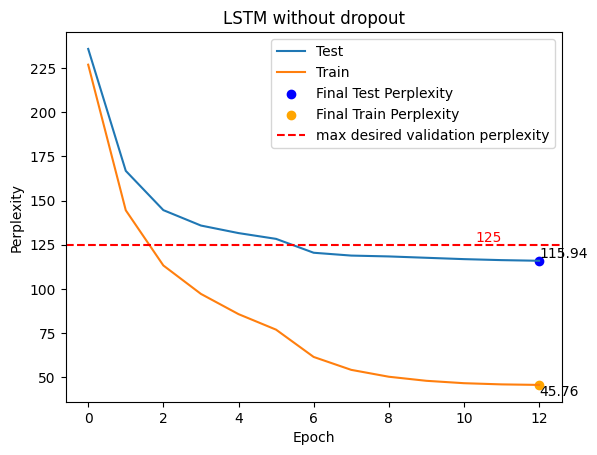

In [12]:
LSTM_without_dropout = test_model(dropout=0,rnn_type='LSTM', total_epochs=13,learning_rate=0.96,winit=0.05,seq_length=35,factor_epoch=5,factor=2,max_grad_norm=5, title="LSTM without dropout")

# Run this cell for : LSTM with dropout

Starting training.

trained over 1327
batch :1 % of train data , train loss = 9.210, learning rate = 0.250, 
batch :10 % of train data , train loss = 6.823, learning rate = 0.250, 
batch :20 % of train data , train loss = 6.674, learning rate = 0.250, 
batch :30 % of train data , train loss = 6.687, learning rate = 0.250, 
batch :40 % of train data , train loss = 6.777, learning rate = 0.250, 
batch :50 % of train data , train loss = 6.664, learning rate = 0.250, 
batch :60 % of train data , train loss = 6.395, learning rate = 0.250, 
batch :70 % of train data , train loss = 6.085, learning rate = 0.250, 
batch :80 % of train data , train loss = 6.434, learning rate = 0.250, 
batch :90 % of train data , train loss = 5.986, learning rate = 0.250, 
batch :100 % of train data , train loss = 6.256, learning rate = 0.250, 
Epoch : 1/70 
            => Validation set perplexity : 464.072
-----------------------------------------------

trained over 1327
batch :1 % of train data , train loss 

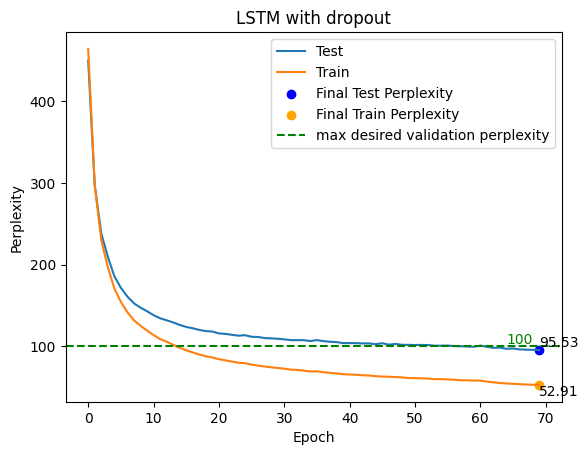

In [17]:
LSTM_with_dropout = test_model(dropout=0.5, rnn_type='LSTM',total_epochs=70, learning_rate=0.25,winit=0.05,seq_length=35,factor_epoch=60,factor=1.2,max_grad_norm=5, title="LSTM with dropout")

# Run this cell for : GRU with dropout

In [ ]:
GRU_with_dropout = test_model(dropout=0.5, rnn_type='GRU', total_epochs=85, learning_rate=0.3,winit=0.05,seq_length=35,factor_epoch=60,factor=1.2,max_grad_norm=5, title="GRU with dropout")

Starting training.

trained over 1327
batch :1 % of train data , train loss = 9.210, learning rate = 0.300, 
batch :10 % of train data , train loss = 6.786, learning rate = 0.300, 
batch :20 % of train data , train loss = 6.590, learning rate = 0.300, 
batch :30 % of train data , train loss = 6.426, learning rate = 0.300, 
batch :40 % of train data , train loss = 6.405, learning rate = 0.300, 
batch :50 % of train data , train loss = 6.207, learning rate = 0.300, 
batch :60 % of train data , train loss = 6.096, learning rate = 0.300, 
batch :70 % of train data , train loss = 5.834, learning rate = 0.300, 
batch :80 % of train data , train loss = 6.178, learning rate = 0.300, 
batch :90 % of train data , train loss = 5.671, learning rate = 0.300, 
batch :100 % of train data , train loss = 5.964, learning rate = 0.300, 
Epoch : 1/85 
            => Validation set perplexity : 328.502
-----------------------------------------------

trained over 1327
batch :1 % of train data , train loss 

# Run this cell for : GRU without dropout

Starting training.

trained over 876
batch :1 % of train data , train loss = 9.211, learning rate = 0.440, 
batch :10 % of train data , train loss = 7.009, learning rate = 0.440, 
batch :20 % of train data , train loss = 6.675, learning rate = 0.440, 
batch :30 % of train data , train loss = 6.707, learning rate = 0.440, 
batch :40 % of train data , train loss = 6.240, learning rate = 0.440, 
batch :50 % of train data , train loss = 6.046, learning rate = 0.440, 
batch :60 % of train data , train loss = 6.185, learning rate = 0.440, 
batch :70 % of train data , train loss = 5.863, learning rate = 0.440, 
batch :80 % of train data , train loss = 6.020, learning rate = 0.440, 
batch :90 % of train data , train loss = 5.712, learning rate = 0.440, 
batch :100 % of train data , train loss = 5.866, learning rate = 0.440, 
Epoch : 1/13 
            => Validation set perplexity : 312.309
-----------------------------------------------

trained over 876
batch :1 % of train data , train loss = 

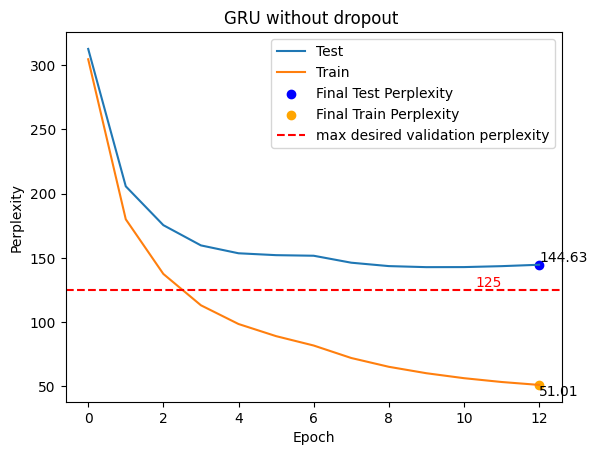

In [13]:
GRU_without_dropout = test_model(dropout=0,rnn_type='GRU',total_epochs=13, learning_rate=0.44,winit=0.05,seq_length=53,factor_epoch=6,factor=1.2330130073607644,max_grad_norm=5.3,title="GRU without dropout ")

# Results Summary: Test, Train, and Validation Perplexity

[((95.89158176415104, 53.201537630127504, 99.62497296821368), 'LSTM with dropout'), ((116.31527137184678, 45.88366964988822, 119.5747533311643), 'LSTM without dropout'), ((97.71310458537349, 48.911015580614254, 101.26951446937052), 'GRU with dropout'), ((141.8704568465457, 58.45235550506949, 145.78068769731348), 'GRU without dropout ')]


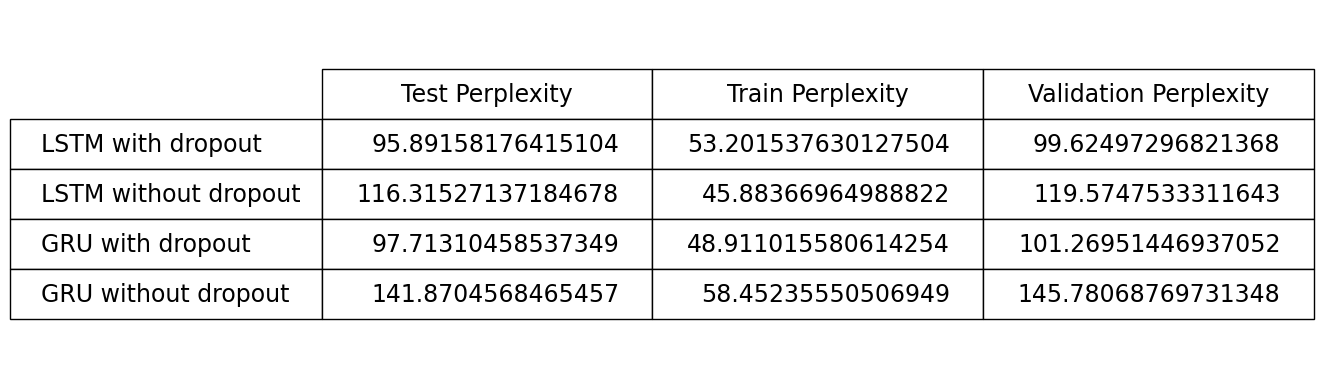

In [ ]:
Values_for_sumuary = [LSTM_with_dropout, LSTM_without_dropout, GRU_with_dropout, GRU_without_dropout]
print(Values_for_sumuary)
columns = ('Test Perplexity', 'Train Perplexity','Validation Perplexity')
rows = [vals[1] for vals in Values_for_sumuary]
vals = [vals[0] for vals in Values_for_sumuary]

__ , ax = plt.subplots()
table = plt.table(cellText=vals,
                      rowLabels=rows,
                      colLabels=columns,
                      loc="center")

table.auto_set_font_size(True)
table.set_fontsize(20)
table.scale(2, 3)
ax.axis('off')


plt.show()
